In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('CTG.csv')

In [3]:
df.head(6)

,Date,Price,Open,High,Low
0,20/01/2016,11656,11931,11931,11656
1,21/01/2016,11311,11587,11725,11242
2,22/01/2016,11104,11311,11380,10897
3,25/01/2016,11862,11380,11862,11380
4,26/01/2016,12000,11725,12000,11587
5,27/01/2016,12069,12000,12276,12000


In [4]:
df.describe()

,Price,Open,High,Low
count,1751.000000,1751.000000,1751.000000,1751.000000
mean,20181.801256,20196.873786,20503.792119,19912.944603
std,7494.386701,7511.964640,7632.885838,7383.449320
min,10069.000000,10069.000000,10242.000000,10035.000000
25%,14236.000000,14231.000000,14419.000000,14053.000000
50%,17372.000000,17372.000000,17633.000000,17149.000000
75%,26550.000000,26470.000000,26950.000000,26035.500000
max,41141.000000,41217.000000,41519.000000,40688.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1751 non-null   object
 1   Price   1751 non-null   int64 
 2   Open    1751 non-null   int64 
 3   High    1751 non-null   int64 
 4   Low     1751 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 68.5+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.head(10)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21280\3973768263.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Price,Open,High,Low
8,2016-01-02,11794,12138,12138,11794
24,2016-01-03,12138,12276,12414,12138
47,2016-01-04,11242,11311,11380,11173
87,2016-01-06,12276,12276,12414,12207
109,2016-01-07,11725,11587,11794,11587
130,2016-01-08,12207,12276,12276,12138
153,2016-01-09,11862,11862,12000,11794
195,2016-01-11,11552,11621,11690,11449
217,2016-01-12,11173,11104,11207,11104
0,2016-01-20,11656,11931,11931,11656


In [7]:
df = pd.read_csv('VCB.csv')

In [8]:
train_size = int(len(df) * 0.8)
test_size = int(len(df) * 0.2)

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [9]:
# In ra kích thước của các tập dữ liệu
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1400, 5)
Test data shape: (350, 5)


In [10]:
# Thực hiện dự đoán AQI cho các ngày trong tương lai sử dụng mô hình Vector Error Correction Model (VECM)
# Bước 1: Kiểm tra tính ổn định của các biến sử dụng Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(data):
    for col in data.columns:
        result = adfuller(data[col])
        print(f'{col}:')
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
            if result[0] > result[4]['5%']:
                print(f'{col} is non-stationary\n')
            else:
                print(f'{col} is stationary\n')

In [11]:
check_stationarity(train_data[['Open', 'High', 'Low']])

Open:
ADF Statistic: -0.438578
p-value: 0.903456
Critical Values:
	1%: -3.435
Open is non-stationary

	5%: -2.864
Open is non-stationary

	10%: -2.568
Open is non-stationary

High:
ADF Statistic: -0.456246
p-value: 0.900276
Critical Values:
	1%: -3.435
High is non-stationary

	5%: -2.864
High is non-stationary

	10%: -2.568
High is non-stationary

Low:
ADF Statistic: -0.477477
p-value: 0.896337
Critical Values:
	1%: -3.435
Low is non-stationary

	5%: -2.864
Low is non-stationary

	10%: -2.568
Low is non-stationary



In [12]:
#Kết quả cho thấy tất cả các biến đều không ổn định, cần phải chuyển sang dữ liệu ổn định
# Bước 2: Chuyển sang dữ liệu ổn định sử dụng first difference
train_diff = train_data[['Open', 'High', 'Low']].diff().dropna()

In [13]:
# Kiểm tra lại tính ổn định

In [14]:
check_stationarity(train_diff)

Open:
ADF Statistic: -10.654486
p-value: 0.000000
Critical Values:
	1%: -3.435
Open is stationary

	5%: -2.864
Open is stationary

	10%: -2.568
Open is stationary

High:
ADF Statistic: -10.598499
p-value: 0.000000
Critical Values:
	1%: -3.435
High is stationary

	5%: -2.864
High is stationary

	10%: -2.568
High is stationary

Low:
ADF Statistic: -10.560356
p-value: 0.000000
Critical Values:
	1%: -3.435
Low is stationary

	5%: -2.864
Low is stationary

	10%: -2.568
Low is stationary



In [15]:
#Kết quả cho thấy các biến đều đã ổn định sau khi sử dụng first difference
# Bước 3: Tìm rank của ma trận cointegration
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

rank = select_coint_rank(train_diff, det_order=0, k_ar_diff=1, method='trace', signif=0.05)
print(rank)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          3323.          29.80
  1   3          2076.          15.49
  2   3          905.9          3.841
-------------------------------------


In [16]:
# Kết quả cho thấy rank = 3, ta sẽ sử dụng rank này để xây dựng
# Bước 4: Xây dựng mô hình VECM với rank = 3

from statsmodels.tsa.vector_ar.vecm import VECM

model = VECM(train_diff, k_ar_diff=1, coint_rank=3, deterministic='ci')
results = model.fit()
print(results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Open
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Open        0.5097      0.154      3.320      0.001       0.209       0.811
L1.High       -0.1904      0.143     -1.334      0.182      -0.470       0.089
L1.Low        -0.1409      0.153     -0.922      0.357      -0.440       0.159
Det. terms outside the coint. relation & lagged endog. parameters for equation High
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.Open        0.1769      0.152      1.162      0.245      -0.122       0.475
L1.High        0.1084      0.141      0.766      0.444      -0.169       0.386
L1.Low        -0.0978      0.152     -0.645      0.519      -0.395       0.199
Det. terms outside the coint. relation & l

C:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
# Bước 5: Dự đoán Price cho test_data
test_diff = test_data[['Open', 'High', 'Low']].diff().dropna()

pred_diff_test = results.predict(steps=len(test_data)-1, alpha=0.05)

In [18]:
# Bước 6: Chuyển kết quả dự đoán về dạng ban đầu
from numpy import cumsum

pred_test = test_data[['Price']].iloc[0].values + cumsum(pred_diff_test)

print(pred_test)

[ 76730.92056022  77661.14589997  78362.62109714 ... 186763.10202872
 194597.3438377  202465.32254765]


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Bước 6.1: Đánh giá hiệu suất của mô hình
actual_values = test_data['Price'].values
predicted_values = pred_test[:len(test_data)]  # Ensure lengths match

# Bước 6.2: Tính toán các chỉ số đánh giá
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
mae = mean_absolute_error(actual_values, predicted_values)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Root Mean Squared Error (RMSE): 8337.85
Mean Absolute Percentage Error (MAPE): 8.68%
Mean Absolute Error (MAE): 6585.06


In [20]:
# Bước 7: Vẽ đồ thị so sánh kết quả thực tế và dự đoán
import matplotlib.pyplot as plt

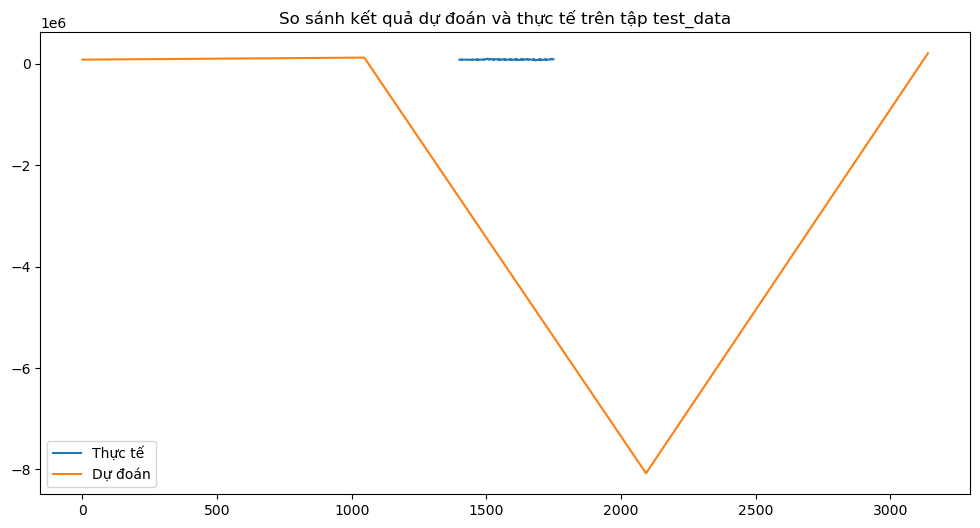

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['Price'], label='Thực tế')
plt.plot(pred_test, label='Dự đoán')
plt.legend()
plt.title('So sánh kết quả dự đoán và thực tế trên tập test_data')
plt.show()

In [22]:
from datetime import datetime, timedelta
# Bước 8: Dự đoán Price cho tương lai
# Chọn ngày bắt đầu và số ngày dự đoán
start_date = datetime.strptime('2023-12-02', '%Y-%m-%d')
num_days = 30

In [23]:
# Tạo DataFrame để lưu trữ kết quả dự đoán
future_data = pd.DataFrame(index=range(num_days), columns=['date', 'Price'])

In [24]:
# Dự đoán và gán giá trị Price cho từng ngày trong tương lai
prev_obs = df.tail(1)[['Open', 'High', 'Low']].values
for i in range(num_days):
    # Dự đoán bước sai lệch
    pred_diff = results.predict(steps=1, alpha=0.05)
    # Chuyển về kết quả dự đoán ban đầu
    pred = prev_obs[0] + cumsum(pred_diff[0])
    # Gán kết quả dự đoán cho ngày tiếp theo
    future_data.loc[i, 'Price'] = pred[-1]
    # Tính lại prev_obs để sử dụng cho dự đoán ngày kế tiếp
    prev_obs = pred.reshape(1, -1)
    # Gán ngày cho từng dòng
    future_data.loc[i, 'date'] = (start_date + timedelta(days=i)).strftime('%Y-%m-%d')

In [25]:
# In kết quả dự đoán
print(future_data)

          date          Price
0   2023-12-02   87220.621097
1   2023-12-03   90641.242194
2   2023-12-04   94061.863291
3   2023-12-05   97482.484389
4   2023-12-06  100903.105486
5   2023-12-07  104323.726583
6   2023-12-08   107744.34768
7   2023-12-09  111164.968777
8   2023-12-10  114585.589874
9   2023-12-11  118006.210971
10  2023-12-12  121426.832069
11  2023-12-13  124847.453166
12  2023-12-14  128268.074263
13  2023-12-15   131688.69536
14  2023-12-16  135109.316457
15  2023-12-17  138529.937554
16  2023-12-18  141950.558651
17  2023-12-19  145371.179748
18  2023-12-20  148791.800846
19  2023-12-21  152212.421943
20  2023-12-22   155633.04304
21  2023-12-23  159053.664137
22  2023-12-24  162474.285234
23  2023-12-25  165894.906331
24  2023-12-26  169315.527428
25  2023-12-27  172736.148526
26  2023-12-28  176156.769623
27  2023-12-29   179577.39072
28  2023-12-30  182998.011817
29  2023-12-31  186418.632914


In [26]:
# Bước 9: Vẽ đồ thị dự đoán Price trong tương lai
pred_test_series = pd.Series(pred_test)

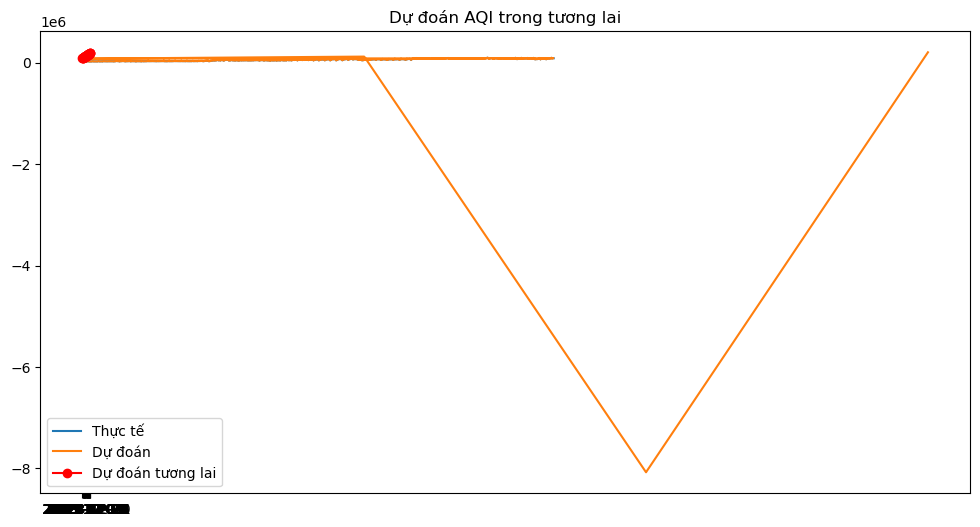

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Thực tế')
pl=pd.concat([df['Price'].iloc[:-1], pred_test_series])
plt.plot(pl, label='Dự đoán')
plt.plot(future_data['date'], future_data['Price'], 'ro-', label='Dự đoán tương lai')
plt.legend()
plt.title('Dự đoán AQI trong tương lai')
plt.show()

In [28]:
# Bước 10: Lưu mô hình VECM
import pickle

with open('vecm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [29]:
# Bước 11: Load mô hình VECM
with open('vecm_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)